The runtime notebook should allow the user to select a saved protocol for each of the two heaters. The user should be able to view the selected protocols. Once the protocols have been selected, the PCR run should commence with the click of a start button and run until either (1) normal completion or (2) the user presses a stop button. A record of the run should be recorded to a data file.

Feedforward Control

In [ ]:
pip install cvxpy

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import linprog
import cvxpy as cp
import ipywidgets as widgets
import tclab
import threading
import datetime
import glob
import pandas as pd

<IPython.core.display.Javascript object>


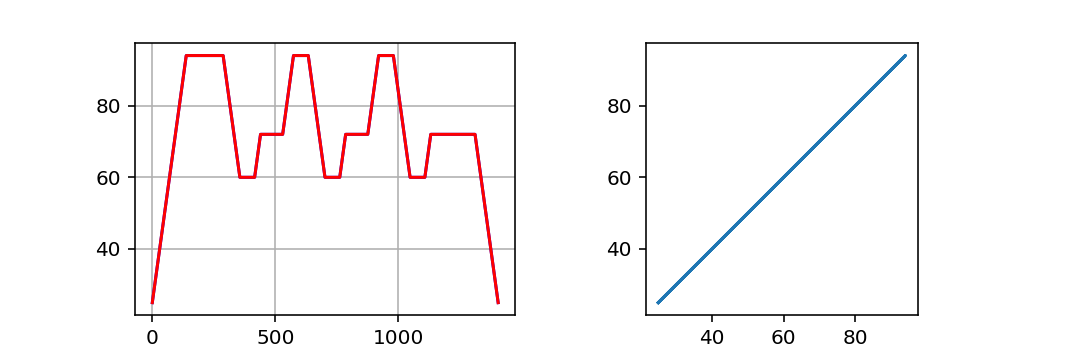

In [34]:
def get_data(file1, file2):
    fig, ax = plt.subplots(1,2, figsize=(7.5,2.5))
    if file1:
        df1 = pd.read_csv(file1)
        ax[0].plot(df1['tp'], df1['Tp'], 'b')
    if file2:
        df2 = pd.read_csv(file2)
        ax[0].plot(df2['tp'], df2['Tp'], 'r')
    ax[0].grid(True)
    if file1 and file2:
        tmax = max(df1['tp'].max(), df2['tp'].max())
        t = np.linspace(0, tmax, int(tmax+1))
        u1 = lambda t: np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
        u2 = lambda t: np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
        ax[1].plot(u1(t), u2(t))
        ax[1].axis('square')
        return u1, u2

SP1, SP2 = get_data('PCR/Heater1Protocol.csv', 'PCR/Heater2Protocol.csv')

## With Start Stop Button/Threading

In [14]:
%matplotlib notebook

# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = SP1(0)
Q_ps = 10
Q1_max = 3.3
Q2_max = 3.3
T_ub = 100
#dt = 5

def feedforward(SP1, SP2, Ta):
    c = np.array([0, 0, 0, 0, 1, 1, 1, 1])
    A_ub = np.array([
        [1, 1, 0, 0, 0, 0, 0, 0]
    ])
    b_ub = np.array([Q_ps])
    A_eq = np.array([
        [-1, 0, (Ua + Ub), -Ub, 0, 0, 0, 0],
        [0, -1, -Ub, (Ua + Ub), 0, 0, 0, 0],
        [0, 0, 1, 0, -1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, -1, 1]
    ])
    b_eq = np.array([Ua*Ta, Ua*Ta, SP1, SP2])
    bounds = [(0, Q1_max), (0, Q2_max), (Ta, T_ub), (Ta, T_ub), (0, None), (0, None), (0, None), (0, None)]
    results = scipy.optimize.linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)
    Q1, Q2, T1, T2, _, _, _, _ = results.x
    return [Q1, Q2, T1, T2]

def PID(Kp, Ki, Kd, MV_bar=0):
    # initialize stored data
    e_prev = 0
    I = 0
    
    # initial control
    MV = MV_bar

    dt=5 #shouldnt be hard coded-- should be passes as parameter
    
    while True:
        # yield MV, wait for new SP, PV
        SP, PV  = yield MV
        #SP, PV, dt = yield MV
        
        # PID calculations
        e = SP - PV
        
        P = Kp*e
        I = I + Ki*e*(dt)
        D = Kd*(e - e_prev)/(dt)
        
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        e_prev = e

TCLab = tclab.setup(connected=False, speedup=5)

def work(stop):
    #with output:
    with TCLab() as lab:

        # pre-run
        lab.P1 = 255
        lab.P2 = 255
        sources = [
            ('T1', lambda: lab.T1),
            ('T2', lambda: lab.T2),
            ('U1', lambda: lab.U1),
            ('U2', lambda: lab.U2),
            ('SP1', lambda: SP1(t)),
            ('SP2', lambda: SP1(t))
        ]
        h = tclab.Historian(sources)
        p = tclab.Plotter(h, 1200, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2')))
        feedback1 = PID(0.5, 0.5,0.5,0)
        _ = feedback1.send(None)
        feedback2 = PID(0.5, 0.5,0.5,0)
        _ = feedback2.send(None)

        # run
        for t in tclab.clock(10000, 5):
            Q1_ff, Q2_ff = feedforward(SP1(t), SP2(t), Ta)
            Q1_fb = feedback1.send([SP1(t), lab.T1])
            Q2_fb = feedback2.send([SP2(t), lab.T2])
            lab.U1 = max(0, min(100, 100*(Q1_ff + Q1_fb)/lab.P1/0.013))
            lab.U2 = max(0, min(100, 100*(Q2_ff + Q2_fb)/lab.P2/0.013))
            p.update(t)
            if stop.value:
                break

        # post-run
        fname = datetime.datetime.now().strftime("Data/data_%Y%M%dT%H%M%S.csv")
        h.to_csv(fname)
        print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
#output_plotter = widgets.Output(layout={'height': '500px', 'border': '1px solid black'})
output_controls = widgets.Output(layout={'height': '90px', 'border': '1px solid black'})

# thread
thread = threading.Thread(target=work, args=(stop))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(output_controls)
with output_controls:
    display(widgets.HBox([start, stop]))
#display(output_plotter)

Output(layout=Layout(border='1px solid black', height='90px'))

## Without Start Stop Button/Threading

TCLab version 0.4.9
Simulated TCLab


<IPython.core.display.Javascript object>


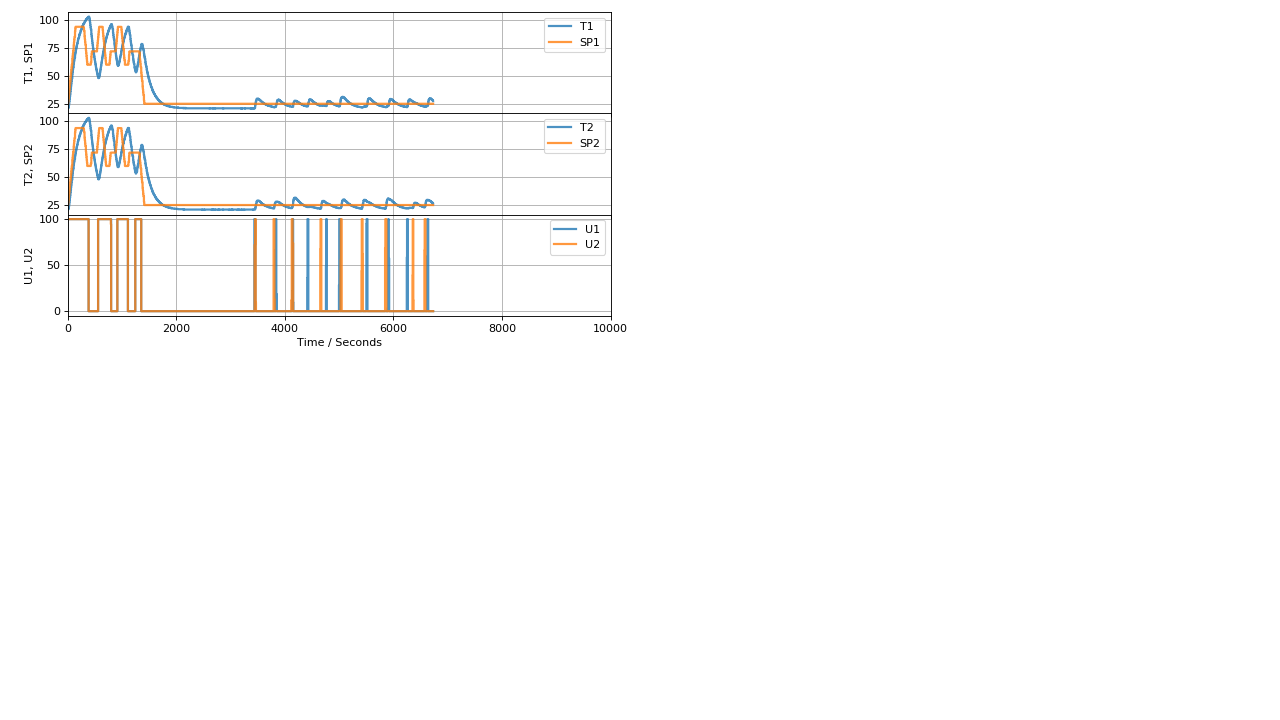

In [ ]:
%matplotlib notebook

# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = SP1(0)
Q_ps = 10
Q1_max = 3.3
Q2_max = 3.3
T_ub = 100
#dt = 5

def feedforward(SP1, SP2, Ta):
    c = np.array([0, 0, 0, 0, 1, 1, 1, 1])
    A_ub = np.array([
        [1, 1, 0, 0, 0, 0, 0, 0]
    ])
    b_ub = np.array([Q_ps])
    A_eq = np.array([
        [-1, 0, (Ua + Ub), -Ub, 0, 0, 0, 0],
        [0, -1, -Ub, (Ua + Ub), 0, 0, 0, 0],
        [0, 0, 1, 0, -1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, -1, 1]
    ])
    b_eq = np.array([Ua*Ta, Ua*Ta, SP1, SP2])
    bounds = [(0, Q1_max), (0, Q2_max), (Ta, T_ub), (Ta, T_ub), (0, None), (0, None), (0, None), (0, None)]
    results = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)
    Q1, Q2, T1, T2, _, _, _, _ = results.x
    return [Q1, Q2, T1, T2]

class PI:
    def __init__(self):
        self.kp = 0.5
        self.ki = 0.5
        self.kd = 0.5

        self.e = 0
        self.e_prev = 0
        self.dt = 1
        
        self.P = 0
        self.I = 0
        self.D = 0
        
    def update(self, sp, pv):
        e = sp - pv
        self.e = e
        
        self.P = self.kp * self.e
        self.I += (self.e*self.ki*self.dt)
        self.D = self.kd * (self.e - self.e_prev)/self.dt
        
        self.mv = self.P + self.I + self.D
        self.e_prev = e
        
        return self.mv

TCLab = tclab.setup(connected=False, speedup=5)

with TCLab() as lab:

    # pre-run
    lab.P1 = 255
    lab.P2 = 255
    sources = [
        ('T1', lambda: lab.T1),
        ('T2', lambda: lab.T2),
        ('U1', lambda: lab.U1),
        ('U2', lambda: lab.U2),
        ('SP1', lambda: SP1(t)),
        ('SP2', lambda: SP1(t))
    ]
    h = tclab.Historian(sources)
    p = tclab.Plotter(h, 10000, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2')))
    feedback1 = PI()
    feedback1.kp = 3
    feedback1.ki = 0.3
    feedback1.kd = 0
    feedback1.dt = 5
    feedback2 = PI()
    feedback2.kp = 3
    feedback2.ki = 0.3
    feedback2.kd = 0
    feedback2.dt = 5

    # run
    for t in tclab.clock(10000, 5):
        Q1_ff, Q2_ff, T1, T2 = feedforward(SP1(t), SP2(t), Ta)
        Q1_fb = feedback1.update(SP1(t), lab.T1)
        Q2_fb = feedback2.update(SP2(t), lab.T2)
        lab.U1 = max(0, min(100, 100*(Q1_ff + Q1_fb)/lab.P1/0.013))
        lab.U2 = max(0, min(100, 100*(Q2_ff + Q2_fb)/lab.P2/0.013))
        p.update(t)

    # post-run
    fname = datetime.datetime.now().strftime("Data/data_%Y%M%dT%H%M%S.csv")
    h.to_csv(fname)
    print("Data saved to", fname)